In [29]:
import sys
sys.path.append('../..')
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt
import scipy.stats as stats

import Functional_Fusion.dataset as fdata

In [2]:
# evaluation dataframe path
path_to_data = "A:\\data\\Cerebellum\\connectivity\\SUIT3\\eval"
df1_path = os.path.join(path_to_data, "MDTB_L2regression_Wm.tsv")
df2_path = os.path.join(path_to_data, "Demand_L2regression_Wm.tsv")


df1 = pd.read_csv(df1_path, sep="\t")
df2 = pd.read_csv(df2_path, sep="\t")

dall = pd.concat([df1,df2],ignore_index=True)

In [3]:
dfall_wm=rm.comb_eval(models=['Wm'],eval_t = 'eval')
dfall_mdtb = rm.comb_eval(models=['Md'],eval_t = 'eval')
dfall_wm["R_eval_norm"] = dfall_wm["R_eval"] / dfall_wm["noiseceiling_XY"]
dfall_mdtb["R_eval_norm"] = dfall_mdtb["R_eval"] / dfall_mdtb["noiseceiling_XY"]

TtestResult(statistic=array([8.44093032]), pvalue=array([4.68080444e-10]), df=array([36]))
TtestResult(statistic=array([2.72686452]), pvalue=array([0.02947185]), df=array([7]))


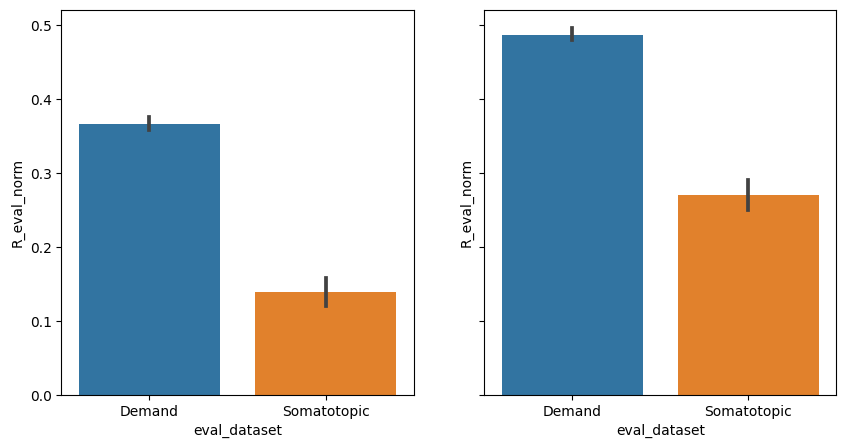

In [4]:
# sns.barplot(data=dfall_wm.loc[(dfall_wm.eval_dataset != "IBC") & (dfall_wm.eval_dataset != "WMFS") & (dfall_wm.eval_dataset != "MDTB")],x='eval_dataset',y='R_eval_norm')

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
sns.barplot(data=dfall_wm.loc[(dfall_wm.eval_dataset != "Nishimoto") \
                              & (dfall_wm.eval_dataset != "WMFS") \
                              & (dfall_wm.eval_dataset != "MDTB")\
                              & (dfall_wm.eval_dataset != "IBC")],
            x='eval_dataset',
            y='R_eval_norm', 
            ax=axes[0])

sns.barplot(data=dfall_mdtb.loc[(dfall_mdtb.eval_dataset != "Nishimoto") \
                                & (dfall_mdtb.eval_dataset != "WMFS") \
                                & (dfall_mdtb.eval_dataset != "MDTB") \
                                & (dfall_mdtb.eval_dataset != "IBC")],
            x='eval_dataset',
            y='R_eval_norm', 
            ax=axes[1])

dd_mdtb_De = dfall_mdtb.loc[(dfall_mdtb.eval_dataset == "Demand")]
A_mdtb_De = pd.pivot_table(dd_mdtb_De,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval_norm'],
                        aggfunc='mean')

dd_mdtb_So = dfall_mdtb.loc[(dfall_mdtb.eval_dataset == "Somatotopic")]
A_mdtb_So = pd.pivot_table(dd_mdtb_So,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval_norm'],
                        aggfunc='mean')

dd_wm_De = dfall_wm.loc[(dfall_wm.eval_dataset == "Demand")]
A_wm_De = pd.pivot_table(dd_wm_De,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval_norm'],
                        aggfunc='mean')

dd_wm_So = dfall_wm.loc[(dfall_wm.eval_dataset == "Somatotopic")]
A_wm_So = pd.pivot_table(dd_wm_So,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval_norm'],
                        aggfunc='mean')
print(stats.ttest_rel(A_mdtb_De.R_eval_norm, A_wm_De.R_eval_norm))
print(stats.ttest_rel(A_mdtb_So.R_eval_norm, A_wm_So.R_eval_norm))
plt.savefig('./conn_model_eval.pdf')

## Fusion vs single datasets

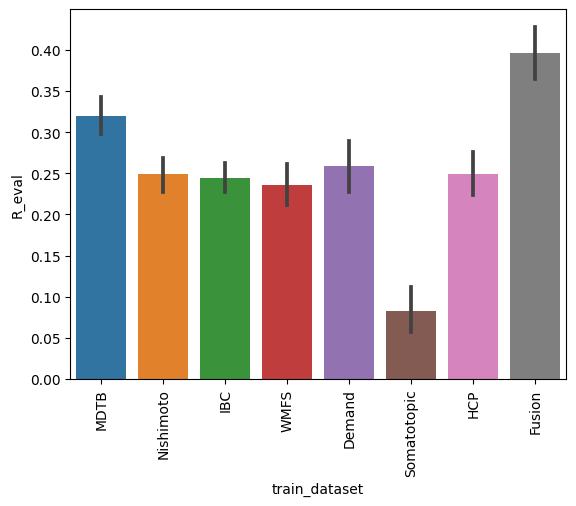

In [28]:
dfall=rm.comb_eval(models=['Md','Ni','Ib','Wm','De','So','Hc','Md-loo','Ni-loo','Ib-loo','Wm-loo','De-loo','So-loo'],eval_t = 'eval')
dfall['model'].fillna('avg',inplace=True)

dfall['nanY']=np.isnan(dfall.noiseceiling_Y)
dfall['nanXY']=np.isnan(dfall.noiseceiling_XY)
dfall['nanXR']=np.isnan(dfall.noise_X_R)

d=dfall[(dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo')]

A = pd.pivot_table(d,index=['train_dataset'],columns=['logalpha'],values=['R_eval'])
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a=np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
dfall['isbest'] = dfall.logalpha.values  == bestla.loc[dfall.train_dataset].values.flatten()

d=dfall[((dfall.train_dataset!=dfall.eval_dataset) | (dfall.model=='loo'))& dfall.isbest]


V=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['R_eval'])
A=pd.pivot_table(d,index=['eval_dataset'],columns=['train_dataset'],values=['noiseceiling_XY'])

V=V.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]
A=A.iloc[[2,3,1,5,0,4],[3,4,2,6,0,5,1]]

# plt.imshow(V.values,cmap='inferno',vmin=0,vmax=0.5)
# ax=plt.gca()
# ev_labels = V.index.values
# tr_labels = A.columns.get_level_values(1).values
# plt.xticks(np.arange(7),tr_labels)
# ax.set_xticklabels(tr_labels, rotation = 90)
# plt.yticks(np.arange(6),ev_labels)
# plt.colorbar()

# Add the favorite Fusion model
dfuse = rm.comb_eval(models=['Fu06-loo'],eval_t = 'eval')

dall = pd.concat([d,dfuse],ignore_index=True)
ho = ['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic','HCP','Fusion']
# ho = ['MDTB','Fusion']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7],[0,0,0]]
sns.barplot(data=dall,x='train_dataset',y='R_eval',order=ho)
ax=plt.gca()
a=ax.set_xticklabels(ho, rotation = 90)


In [43]:
dall["R_eval_norm"] = dall["R_eval"] / dall["noiseceiling_XY"]
AA1 = pd.pivot_table(dfuse,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval'],
                        aggfunc='mean')

AA2 = pd.pivot_table(d,
                        index=['eval_subj'],
                        columns=['eval_dataset'],
                        values=['R_eval'],
                        aggfunc='mean')
print(stats.ttest_rel(AA1.R_eval, AA2.R_eval, nan_policy='omit'))

TtestResult(statistic=array([18.58330406,  7.98240456, 20.30356474, 20.4799983 ,  4.97916338,
        9.24328623]), pvalue=array([4.90864185e-20, 6.67037457e-06, 3.48121950e-16, 5.13598587e-06,
       1.60249767e-03, 1.39262779e-07]), df=array([36., 11., 23.,  5.,  7., 15.]))


## Group vs individual

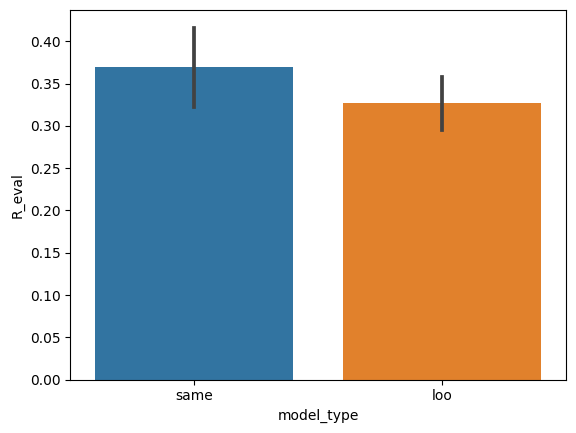

In [44]:
# evaluate model trained on S1 on S2
df2=rm.comb_eval(models=['Mds1-ind','MDs1-avg','MDs1-loo'],eval_data=['MDTBs2'], eval_t = 'eval_noint')
df2['model_type'] = df2['model']
df2.loc[df2['model'].isna() & (df2.subj_id != df2.eval_subj),'model_type']='diff'
df2.loc[df2['model'].isna() & (df2.subj_id == df2.eval_subj),'model_type']='same'
dd = df2.loc[(df2.model_type == "same") | (df2.model_type == "loo")]
sns.barplot(data=dd,x='model_type',y='R_eval')

plt.savefig('./conn_model_groupVind_eval.pdf')

In [47]:
# tests
AA2 = pd.pivot_table(df2,
                        index=['eval_subj'],
                        columns=['model_type'],
                        values=['R_eval'],
                        aggfunc='mean')
print(stats.ttest_rel(AA2.R_eval.same, AA2.R_eval.loo, nan_policy='omit'))

TtestResult(statistic=2.2179596913117883, pvalue=0.036712171619699495, df=23)


In [50]:
TtestResult = stats.ttest_rel(AA2.R_eval.same, AA2.R_eval.loo, nan_policy='omit')
TtestResult.df

23